# Creating layer class

In [2]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
import matplotlib.pyplot as plt

In [3]:
np.random.seed(0)

# Neural layer class

In [23]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.10 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        
    def forward(self, inputs):
        self.inputs = inputs # Remember inputs for backpropagation
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        # Calculate gradient on inputs
        self.dinputs = np.dot(dvalues, self.weights.T)

# Creating ReLu Activation Function

In [24]:
class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs # Remember inputs for backpropagation
        
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        
        # Calculate gradient on inputs
        self.dinputs[self.inputs <= 0] = 0

# Softmax Activation Function

In [25]:
class Activation_Softmax:
    def forward(self, inputs):
        self.inputs = inputs # Remember inputs for backpropagation
        
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        
        self.output = probabilities

    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)

        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):

            single_output = single_output.reshape(-1, 1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)

            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

# Categorical Cross-Entropy Loss Function

In [26]:
class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

class Loss_CategoricalCrossEntropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

        # Check shape of targets
        if len(y_true.shape) == 1:
            # Data is [0,1,0]...
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) == 2:
            # Data is [[1,0],[0,1],[1,0]]
            correct_confidences = np.sum(y_pred_clipped*y_true, axis=1)
        
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])

        # Turn labelse into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient on inputs
        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples # Normalize

# Softmax combined with Categorical Cross-Entropy

In [27]:
class Activation_Softmax_Loss_CategoricalCrossentropy():
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossEntropy()

    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output

        # Calculate loss
        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)

        # Reshape targets if [[0,1], [1,0]]
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dinputs = dvalues.copy()

        # Calculate gradient on inputs
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs / samples

# Stochastic Gradient Descent optimizer

In [28]:
class Optimizer_SGD():
    def __init__(self, learning_rate=1):
        self.learning_rate = learning_rate
    
    def update_params(self, layer):
        layer.weights += -self.learning_rate * layer.dweights
        layer.biases += -self.learning_rate * layer.dbiases

# Getting results

In [4]:
X, y = spiral_data(samples=100, classes=3)

### Classes

In [45]:
# Hidden layer
layer1 = Layer_Dense(2, 64)
activation1 = Activation_ReLU()

# Output layer
layer2 = Layer_Dense(64, 3)
activation2 = Activation_Softmax()

# Loss
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Optimizer
optimizer = Optimizer_SGD(learning_rate=1.2)

In [46]:
for epoch in range(10001):
    # Forward pass on first layer
    layer1.forward(X)
    activation1.forward(layer1.output)

    # Forward pass on second layer
    layer2.forward(activation1.output)

    # Calculate loss
    loss = loss_activation.forward(layer2.output, y)

    # Calculate accuracy
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)

    if not epoch % 500:
        print(f'epoch: {epoch}, acc: {accuracy:.3f}, loss: {loss:.3f}')
    
    # Backpropogation
    loss_activation.backward(loss_activation.output, y)
    layer2.backward(loss_activation.dinputs)
    activation1.backward(layer2.dinputs)
    layer1.backward(activation1.dinputs)

    # Optimize weights and bias
    optimizer.update_params(layer1)
    optimizer.update_params(layer2)

epoch: 0, acc: 0.390, loss: 1.098
epoch: 500, acc: 0.473, loss: 1.047
epoch: 1000, acc: 0.523, loss: 0.961
epoch: 1500, acc: 0.603, loss: 0.867
epoch: 2000, acc: 0.580, loss: 0.923
epoch: 2500, acc: 0.700, loss: 0.736
epoch: 3000, acc: 0.673, loss: 0.742
epoch: 3500, acc: 0.690, loss: 0.721
epoch: 4000, acc: 0.690, loss: 0.701
epoch: 4500, acc: 0.787, loss: 0.494
epoch: 5000, acc: 0.780, loss: 0.527
epoch: 5500, acc: 0.783, loss: 0.500
epoch: 6000, acc: 0.797, loss: 0.464
epoch: 6500, acc: 0.787, loss: 0.512
epoch: 7000, acc: 0.817, loss: 0.439
epoch: 7500, acc: 0.817, loss: 0.425
epoch: 8000, acc: 0.823, loss: 0.414
epoch: 8500, acc: 0.820, loss: 0.400
epoch: 9000, acc: 0.827, loss: 0.419
epoch: 9500, acc: 0.847, loss: 0.388
epoch: 10000, acc: 0.857, loss: 0.384


# The original dataset

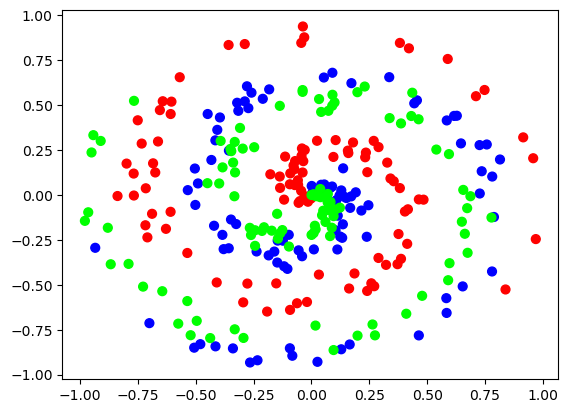

In [47]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='brg')
plt.show()

# My networks prediction

In [48]:
y_pred = []

for observation in X:
    # Forward pass on first layer
    layer1.forward(observation)
    activation1.forward(layer1.output)
    
    # Forward pass on second layer
    layer2.forward(activation1.output)
    activation2.forward(layer2.output)
    
    prediction = np.argmax(activation2.output)
    y_pred.append(prediction)

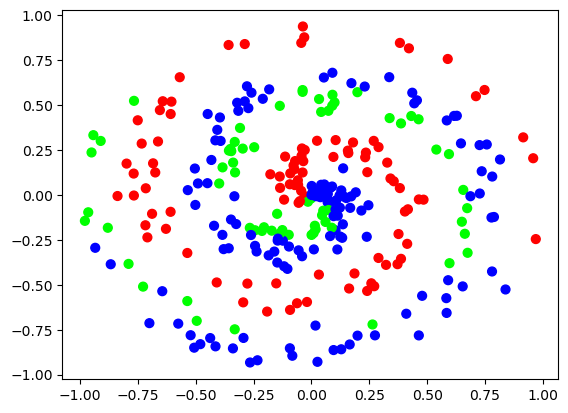

In [49]:
plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=40, cmap='brg')
plt.show()